In [1]:
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier

In [2]:
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from util import calculate_weights, train_validation_test_split, get_statistics
from dataset import DatasetGenerator
from custom_transforms import ShuffleChannel
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from models import PretrainedModel, resnet18
from sklearn.metrics import f1_score

In [3]:
from skorch.callbacks import LRScheduler
import torch.optim as optim
from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from collections import Counter

In [4]:
import iflai

#### Set all random seeds to the specific value, so the results are more reproducable

In [5]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

#### Define all necessary parameters

In [6]:
dataset_name = "wbc"
selected_channels = np.arange(12)
path_to_data ="..\..\data/WBC"
model_dir = "models_remote"
scaling_factor = 4095.
reshape_size = 64
num_channels = len(selected_channels)
train_transform = [
         transforms.RandomVerticalFlip(),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(45)
        ]
test_transform = [ ]
channels =np.asarray([ "Ch" + str(i) for i in selected_channels])

In [7]:
batch_size = 64
num_workers = 2
device="cpu"

#### Load data

In [8]:
%time

metadata = iflai.metadata_generator(path_to_data)

Wall time: 0 ns
Metadata prepration starts...
experiment donor condition


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31280/31280 [00:07<00:00, 4126.22it/s]


...metadata prepration ended.


In [9]:
indx = metadata["label"] != "unknown"
metadata = metadata.loc[indx,:]
metadata = metadata.reset_index(drop = True)

#### Split data

In [10]:
train_index, validation_index, test_index = train_validation_test_split(metadata.index, metadata["label"], random_state=seed_value)

In [11]:
label_map = dict(zip(sorted(set(metadata.loc[train_index, "label"])), np.arange(len(set(metadata.loc[train_index, "label"])))))

In [12]:
label_map

{b'CD14+ monocyte': 0,
 b'CD15+ neutrophil': 1,
 b'CD19+ B': 2,
 b'CD4+ T': 3,
 b'CD56+ NK': 4,
 b'CD8+ T': 5,
 b'NKT': 6,
 b'eosinophil': 7,
 b'unknown': 8}

#### Oversamle and use class weights for imbalance data / Skip if not required

In [ ]:
y_train = [label_map.get(metadata.loc[i, "label"]) for i in train_index]
weights = calculate_weights(y_train)
oversample = RandomOverSampler(random_state=seed_value, sampling_strategy='all')

In [ ]:
Counter(y_train)

In [ ]:
train_index, y_train = oversample.fit_resample(np.asarray(train_index).reshape(-1, 1), y_train)
train_index = train_index.T[0]

In [ ]:
Counter(y_train)

#### Calculate statistics of train set and normalize the data

In [13]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:], label_map=label_map, selected_channels=selected_channels, scaling_factor=scaling_factor, transform=transforms.Compose(train_transform))

In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

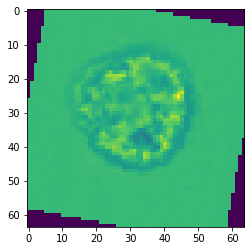

In [15]:
plt.imshow(train_dataset[0][0][0])

In [16]:
statistics = get_statistics(train_loader, selected_channels=np.arange(12))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [04:21<00:00,  1.20it/s]

statistics used: {'min': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'p01': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'p05': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'p25': tensor([0.1921, 0.0032, 0.0139, 0.0049, 0.0071, 0.0090, 0.0103, 0.0079, 0.1888,
        0.0120, 0.0047, 0.0082]), 'p50': tensor([0.1966, 0.0040, 0.0144, 0.0051, 0.0076, 0.0098, 0.0110, 0.0084, 0.1921,
        0.0131, 0.0055, 0.0085]), 'p75': tensor([0.1979, 0.0084, 0.0147, 0.0056, 0.0078, 0.0129, 0.0117, 0.0102, 0.1936,
        0.0141, 0.0063, 0.0088]), 'p95': tensor([0.2090, 0.0649, 0.0156, 0.0062, 0.0084, 0.0486, 0.0280, 0.0249, 0.2049,
        0.0162, 0.0073, 0.0095]), 'p99': tensor([0.2315, 0.1167, 0.0182, 0.0097, 0.0090, 0.1018, 0.0722, 0.0417, 0.2271,
        0.0273, 0.0082, 0.0141]), 'max': tensor([0.3464, 0.7831, 0.0413, 0.0301, 0.0180, 0.7042, 0.2737, 0.1221, 0.3525,
        0.0799, 0.0223, 0.0606]), 'mean': tensor([0.1728, 0.0134, 0.0128, 0.0048, 0.0067, 0.015

In [17]:
train_transform.append(transforms.Normalize(mean=statistics["mean"],
                         std=statistics["std"]))

In [18]:
test_transform.append(transforms.Normalize(mean=statistics["mean"],
                         std=statistics["std"]))

In [19]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 transform= transforms.Compose(train_transform))

In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [21]:
num_classes = len(label_map.keys())

In [22]:
validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:], label_map=label_map, selected_channels=np.arange(12), scaling_factor=scaling_factor, transform= transforms.Compose(test_transform))
test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:], label_map=label_map, selected_channels=np.arange(12), scaling_factor=scaling_factor, transform= transforms.Compose(test_transform))

In [23]:
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#### Set all hyperparameters for the model

In [24]:
lrscheduler = LRScheduler(
    policy='StepLR', step_size=7, gamma=0.5)

In [25]:
checkpoint = Checkpoint(
    f_params='wbc_net_all_.pth', monitor='valid_loss_best', dirname='models')
train_end_cp = TrainEndCheckpoint(f_params='final_wbc_net_all_.pth', dirname='models')

In [26]:
class_weights = torch.FloatTensor(weights).to(device)

NameError: name 'weights' is not defined

### Initialite and train the model

In [27]:
num_classes

9

In [28]:
net = NeuralNetClassifier(
    PretrainedModel, 
    criterion=nn.CrossEntropyLoss,
    #criterion__weight=class_weights,
    lr=0.001,
    batch_size=64,
    max_epochs=10,
    module__output_features=num_classes,
    module__num_classes=num_classes,
    module__num_channels=num_channels, 
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=False,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    callbacks=[lrscheduler, checkpoint, train_end_cp],
    train_split=predefined_split(validation_dataset),
    #device='cuda' # comment to train on cpu
)

In [29]:
net.fit(train_dataset, y=None)

  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        0.2502       0.9568        0.1421     +  0.0010  248.7521
      2        0.1051       0.9790        0.0803     +  0.0010  248.9242
      3        0.0833       0.9826        0.0701     +  0.0010  249.3353
      4        0.0741       0.9788        0.0766        0.0010  248.8793
      5        0.0672       0.9690        0.0924        0.0010  248.4701
      6        0.0610       0.9830        0.0660     +  0.0010  247.1388
      7        0.0568       0.9814        0.0629     +  0.0010  249.4662
      8        0.0479       0.9858        0.0541     +  0.0005  249.5192
      9        0.0449       0.9862        0.0549        0.0005  249.3511
     10        0.0434       0.9850        0.0559        0.0005  249.6280


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PretrainedModel(
    (model): ResNet(
      (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64

### Model Evaluation

In [30]:
#net.save_params(f_params='final_wbc_net_all_.pth')
model = PretrainedModel(num_classes, num_channels)
checkpoint = torch.load('models/wbc_net_all_.pth')
model.load_state_dict(checkpoint)
model = model.to(device)

In [31]:
correct = 0.
total = 0.
y_true = list()
y_pred = list()
y_true_proba = list()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).long()
        #Tracer()()
        outputs = model(inputs)
        pred = outputs.argmax(dim=1)
        true_proba = np.array([j[i] for (i,j) in zip(pred, outputs)])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.reshape(-1) == predicted).sum().item()
        for i in range(len(pred)):
            y_true.append(labels[i].item())
            y_pred.append(pred[i].item())
            y_true_proba.append(true_proba[i].item())

In [32]:
class_names_targets = [c.decode("utf-8") for c in label_map.keys()]

In [33]:
print(classification_report(y_true, y_pred, target_names=class_names_targets, digits=4))

                  precision    recall  f1-score   support

  CD14+ monocyte     0.9697    1.0000    0.9846       256
CD15+ neutrophil     0.9881    0.9997    0.9939      3665
         CD19+ B     0.9887    0.9831    0.9859       178
          CD4+ T     0.9898    0.9788    0.9843       895
        CD56+ NK     0.9909    0.8134    0.8934       134
          CD8+ T     0.9548    0.9441    0.9494       358
             NKT     0.7634    0.8301    0.7953       206
      eosinophil     0.9933    0.9674    0.9802       307
         unknown     0.7957    0.7276    0.7602       257

        accuracy                         0.9707      6256
       macro avg     0.9372    0.9160    0.9253      6256
    weighted avg     0.9707    0.9707    0.9704      6256



### Model Interpretation

In [34]:
# where to save results
model_name = "wbc"

#### Pixel-Permutation Tests

In [35]:
from time import process_time

In [ ]:
t1_start = process_time()
f1_score_original = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
min_mean_dif = 1.0
candidate = 0
shuffle_times = 5
df_all = pd.DataFrame([], columns=class_names_targets)
for c in range(num_channels):
    f1_score_diff_from_original_per_channel_per_shuffle = []
    transform = test_transform.copy()
    transform.append(ShuffleChannel(channels_to_shuffle=[c]))
    for s in range(shuffle_times):
        dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                   label_map=label_map,
                                   selected_channels=np.arange(12),
                                   scaling_factor=scaling_factor,
                                   transform=transforms.Compose(transform))
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)
        y_true = list()
        y_pred = list()
        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
                outputs = model(inputs)
                pred = outputs.argmax(dim=1)
                for i in range(len(pred)):
                    y_true.append(labels[i].item())
                    y_pred.append(pred[i].item())
            f1_score_per_channel = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
            f1_score_diff_from_original_per_channel_per_shuffle.append(f1_score_original - f1_score_per_channel)
    mean_along_columns = np.mean(f1_score_diff_from_original_per_channel_per_shuffle, axis=0)
    mean_dif = np.mean(mean_along_columns)
    if mean_dif < min_mean_dif and mean_dif > 0 and not selected_channels[c]:
        min_mean_dif = mean_dif
        candidate = selected_channels[c]
    df_diff = pd.DataFrame(np.atleast_2d(f1_score_diff_from_original_per_channel_per_shuffle), columns=class_names_targets)
    df_mean_diff = pd.DataFrame(np.atleast_2d(mean_along_columns), columns=class_names_targets)
    df_all = pd.concat([df_all, df_mean_diff], ignore_index=True, sort=False)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = df_diff.boxplot()
    ax.set_xticklabels(class_names_targets, rotation=45)
    fig.savefig(os.path.join("results",model_name, "{}-shuffle_method-model-{}-channel-{}.png".format(dataset_name, str(model_name), str(selected_channels[c]))))
print("Candidate channel is {}".format(candidate))

In [ ]:
df_all

In [ ]:
plt.bar(channels[selected_channels], df_all.T.mean(), color='Grey')
plt.savefig(os.path.join("results",model_name, "{}-pixel-permutation-method-model-all-{}.png".format(dataset_name, str("resnet_all"))))

In [ ]:
channel_ranking_pixel_permutation = pd.DataFrame(data={'channels': channels[np.asarray(selected_channels)], 'importance': df_all.T.mean().to_numpy()})

In [ ]:
channel_ranking_pixel_permutation

### Evaluate the method with AOPC

In [36]:
def calculate_aopc(channel_ranking, method='', ascending=False, plot=True, perturb=False):
    #channel_ranking = pd.DataFrame(data={"channels":channels_ranking, "importance": importance})
    sorted_channels = channel_ranking.sort_values(by="importance", ascending=ascending)
    channels_to_permute=[]
    differences = []
    # calculate (f^0 - f^k)
    for i in range(len(sorted_channels)):
        channels_to_permute.append(np.where(channels==sorted_channels.iloc[i]["channels"])[0][0])
        transform = test_transform.copy()
        transform.append(ShuffleChannel(channels_to_shuffle=channels_to_permute, perturb=perturb))
        dataset_ = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                    label_map=label_map,
                                    selected_channels=np.arange(12),
                                    transform= transforms.Compose(transform),
                                    scaling_factor=scaling_factor)
        dataloader_ = DataLoader(dataset_,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)
        
        y_true_permut_proba = list()
        with torch.no_grad():
            for data in dataloader_:
                inputs, labels = data[0].to(device).float(), data[1].to(device).long()
                outputs = model(inputs)
                pred = outputs.argmax(dim=1)
                permut_proba = np.array([j[i] for (i,j) in zip(pred, outputs)])
                _, predicted = torch.max(outputs.data, 1)
                for i in range(len(pred)):
                    y_true_permut_proba.append(permut_proba[i].item())
        differences.append(y_true_proba-np.array(y_true_permut_proba))
    stacked_diff = np.stack(differences)
    # calculate summ(f^0-f^k)
    diff_accumulated = []
    for idx, diff in enumerate(stacked_diff):
        if idx==0:
            diff_accumulated.append(stacked_diff[idx])
        else:
            diff_accumulated.append(diff_accumulated[idx-1] + stacked_diff[idx])
    diff_accumulated = np.stack(diff_accumulated)
    # mean over the test set
    diff_accumulated_mean = np.mean(diff_accumulated, axis=-1)
    # divide by 1/L+1
    diff_accumulated_mean_norm = np.array([])
    for ix, d in enumerate(diff_accumulated_mean):
        diff_accumulated_mean_norm = np.append(diff_accumulated_mean_norm, d/(ix+1))
    # insert (0,0)
    diff_accumulated_mean_norm_started_from_0 = np.insert(diff_accumulated_mean_norm,0,0.0)
    # plot line
    if plot:
        x = np.arange(len(diff_accumulated_mean_norm_started_from_0))
        plt.xlabel("permutation steps")
        plt.ylabel("AOPC")
        plt.plot(x, diff_accumulated_mean_norm_started_from_0, color ="red")
        #plt.show()
        plt.savefig(os.path.join("results",model_name, "{}-aopc-{}-{}.svg".format(dataset_name, method, str("resnet_all"))))
    return diff_accumulated_mean_norm_started_from_0

In [37]:
res_pixel_permutated_perturb_reverse = calculate_aopc(channel_ranking_pixel_permutation, method='pixel-permutation-perturb', perturb=True, ascending=False)

NameError: name 'channel_ranking_pixel_permutation' is not defined

### Interpretation by methods from captum

In [60]:
from captum.attr import (
    GuidedGradCam,
    DeepLift,
    Saliency,
    DeepLiftShap,
    GradientShap,
    InputXGradient,
    IntegratedGradients,
    GuidedBackprop,
    Deconvolution,
    Occlusion,
    FeaturePermutation,
    ShapleyValueSampling,
    Lime,
    KernelShap,
    LRP
)
from time import process_time

#### Occlusion

In [ ]:
t1_start = process_time()
ablator = Occlusion(model)
dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                           label_map=label_map,
                           selected_channels=np.arange(12),
                           transform=transforms.Compose(test_transform),
                           scaling_factor=scaling_factor)
dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)

heatmaps = torch.empty(0, dtype=torch.float32, device=device)
with torch.no_grad():
    for data in dataloader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
        attr = ablator.attribute(inputs, target=labels, sliding_window_shapes=(1,3,3))
        heatmaps = torch.cat((heatmaps, torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(dev)))
heatmaps_mean = torch.mean(heatmaps, dim=0)
plt.bar(channels[np.asarray(only_channels)], heatmaps_mean.cpu(), color='grey')
plt.savefig(os.path.join("results",model_name, "{}-occl_method-model-50-percentile-{}.png".format(dataset_name, str("resnet_all"))))

t1_stop = process_time()
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start) 

In [ ]:
channel_ranking_occlusion = pd.DataFrame(data={'channels': channels[np.asarray(only_channels)], 'importance': heatmaps_mean.cpu().numpy()})

In [ ]:
channel_ranking_occlusion

In [ ]:
res_pixel_ocll_perturb_reverse = calculate_aopc(channel_ranking_occlusion, method='pixel-occlusion-perturb-reverse', ascending=False, perturb=True)

#### DeepLift

Elapsed time: 17384.671875 16297.765625
Elapsed time during the whole program in seconds: 1086.90625


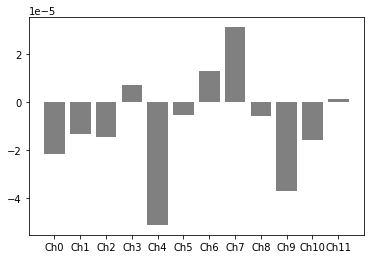

In [39]:
t1_start = process_time()
ablator = DeepLift(model)

dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                           label_map=label_map,
                           selected_channels=np.arange(12),
                           transform=transforms.Compose(test_transform),
                           scaling_factor=scaling_factor)
testloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)

heatmaps_deeplift = torch.empty(0, dtype=torch.float32, device=device)
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
        # baselines=torch.zeros(inputs.shape).to(dev)
        attr = ablator.attribute(inputs, target=labels)
        heatmaps_deeplift = torch.cat((heatmaps_deeplift,  torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(device)))
heatmaps_deeplift_mean = torch.mean(heatmaps_deeplift, dim=0)
plt.bar(channels, heatmaps_deeplift_mean.cpu(), color='grey')
plt.savefig(os.path.join("results", "resnet_all", "{}-deeplift_method-model-50-percentile-{}.png".format(dataset_name, str("resnet_all"))))

t1_stop = process_time()
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start) 

In [40]:
channel_ranking_deep_lift = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_deeplift_mean.cpu().numpy()})

In [41]:
channel_ranking_deep_lift

,channels,importance
0,Ch0,-0.000021
1,Ch1,-0.000013
2,Ch2,-0.000015
3,Ch3,0.000007
4,Ch4,-0.000051
5,Ch5,-0.000005
6,Ch6,0.000013
7,Ch7,0.000031
8,Ch8,-0.000006
9,Ch9,-0.000037


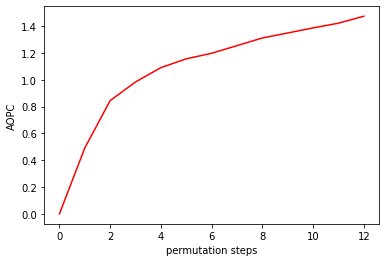

In [42]:
res_deep_lift_perturb_reverse = calculate_aopc(channel_ranking_deep_lift, method='deep-lift-aopc', ascending=False, perturb=True)

#### Saliency

Elapsed time: 22178.96875 21606.25
Elapsed time during the whole program in seconds: 572.71875


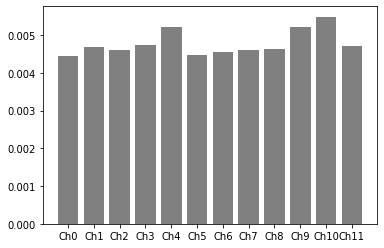

In [50]:
t1_start = process_time()
ablator = Saliency(model)

dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                           label_map=label_map,
                           selected_channels=np.arange(12),
                           transform=transforms.Compose(test_transform),
                           scaling_factor=scaling_factor)
testloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)

heatmaps_saliency = torch.empty(0, dtype=torch.float32, device=device)
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
        # baselines=torch.zeros(inputs.shape).to(dev)
        attr = ablator.attribute(inputs, target=labels)
        heatmaps_saliency = torch.cat((heatmaps_saliency, torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(device)))
heatmaps_saliency_mean = torch.mean(heatmaps_saliency, dim=0)
plt.bar(channels, heatmaps_saliency_mean.cpu(), color='grey')
plt.savefig(os.path.join("results", "resnet_all", "{}-saliency_method-model-50-percentile-{}.png".format(dataset_name, str("resnet_all"))))

t1_stop = process_time()
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start) 

In [51]:
channel_ranking_saliency = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_saliency_mean.cpu().numpy()})

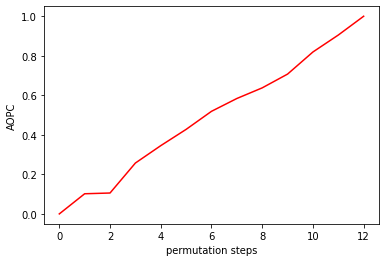

In [52]:
res_saliency_perturb_reverse = calculate_aopc(channel_ranking_saliency, method='saliency-aopc', ascending=False, perturb=True)

#### Integrated Gradients

Elapsed time: 42496.09375 23974.34375
Elapsed time during the whole program in seconds: 18521.75


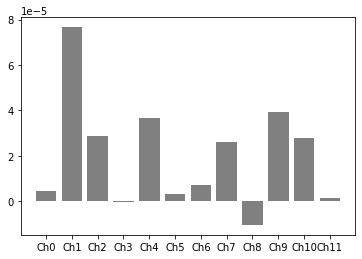

In [53]:
t1_start = process_time()
ablator = IntegratedGradients(model)

dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                           label_map=label_map,
                           selected_channels=np.arange(12),
                           transform=transforms.Compose(test_transform),
                           scaling_factor=scaling_factor)
testloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)

heatmaps_integrated_gradient = torch.empty(0, dtype=torch.float32, device=device)
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
        # baselines=torch.zeros(inputs.shape).to(dev)
        attr = ablator.attribute(inputs, target=labels)
        heatmaps_integrated_gradient = torch.cat((heatmaps_integrated_gradient,  torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(device)))
heatmaps_integrated_gradient_mean = torch.mean(heatmaps_integrated_gradient, dim=0)
plt.bar(channels, heatmaps_integrated_gradient_mean.cpu(), color='grey')
plt.savefig(os.path.join("results", "resnet_all", "{}-integrated_gradient_method-model-50-percentile-{}.png".format(dataset_name, str("resnet_all"))))

t1_stop = process_time()
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start)

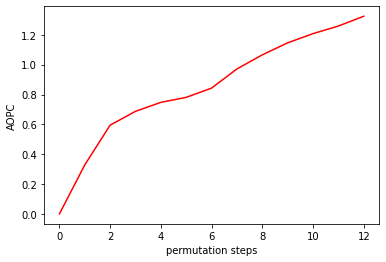

In [54]:
channel_ranking_integrated_gradient = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_integrated_gradient_mean.cpu().numpy()})
res_integrated_gradient_perturb_reverse = calculate_aopc(channel_ranking_integrated_gradient, method='integrated_gradient-aopc', ascending=False, perturb=True)

#### LIME

Elapsed time: 263110.765625 43899.515625
Elapsed time during the whole program in seconds: 219211.25


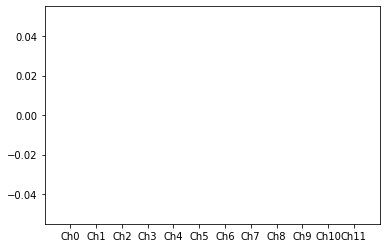

In [55]:
t1_start = process_time()
ablator = Lime(model)

dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                           label_map=label_map,
                           selected_channels=np.arange(12),
                           transform=transforms.Compose(test_transform),
                           scaling_factor=scaling_factor)
testloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)

heatmaps_lime = torch.empty(0, dtype=torch.float32, device=device)
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
        # baselines=torch.zeros(inputs.shape).to(dev)
        attr = ablator.attribute(inputs, target=labels)
        heatmaps_lime = torch.cat((heatmaps_lime,  torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(device)))
heatmaps_lime_mean = torch.mean(heatmaps_lime, dim=0)
plt.bar(channels, heatmaps_lime_mean.cpu(), color='grey')
plt.savefig(os.path.join("results", "resnet_all", "{}-lime_method-model-50-percentile-{}.png".format(dataset_name, str("resnet_all"))))

t1_stop = process_time()
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start)

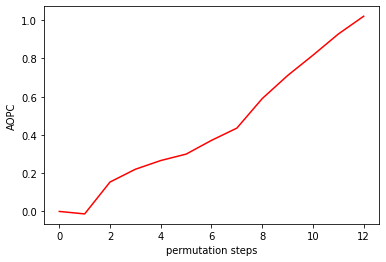

In [56]:
channel_ranking_lime = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_lime_mean.cpu().numpy()})
res_lime_mean_perturb_reverse = calculate_aopc(channel_ranking_lime, method='lime-aopc', ascending=False, perturb=True)

#### Deconvolution

Elapsed time: 265011.5 264542.078125
Elapsed time during the whole program in seconds: 469.421875


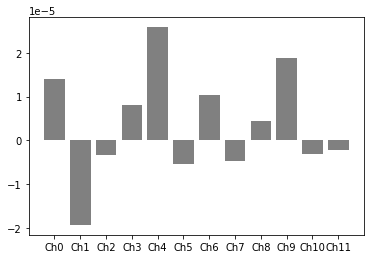

In [57]:
t1_start = process_time()
ablator = GuidedBackprop(model)

dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                           label_map=label_map,
                           selected_channels=np.arange(12),
                           transform=transforms.Compose(test_transform),
                           scaling_factor=scaling_factor)
testloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)

heatmaps_deconv = torch.empty(0, dtype=torch.float32, device=device)
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
        # baselines=torch.zeros(inputs.shape).to(dev)
        attr = ablator.attribute(inputs, target=labels)
        heatmaps_deconv = torch.cat((heatmaps_deconv,  torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(device)))
heatmaps_deconv_mean = torch.mean(heatmaps_deconv, dim=0)
plt.bar(channels, heatmaps_deconv_mean.cpu(), color='grey')
plt.savefig(os.path.join("results", "resnet_all", "{}-deconv_method-model-50-percentile-{}.png".format(dataset_name, str("resnet_all"))))

t1_stop = process_time()
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start)

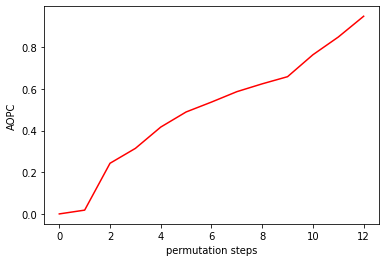

In [58]:
channel_ranking_deconv = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_deconv_mean.cpu().numpy()})
res_deconv_mean_perturb_reverse = calculate_aopc(channel_ranking_deconv, method='deconv-aopc', ascending=False, perturb=True)

#### LRP

Elapsed time: 267122.921875 266419.515625
Elapsed time during the whole program in seconds: 703.40625


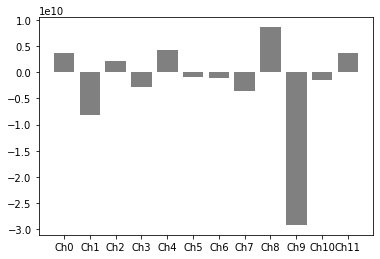

In [61]:
t1_start = process_time()
ablator = LRP(model)

dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                           label_map=label_map,
                           selected_channels=np.arange(12),
                           transform=transforms.Compose(test_transform),
                           scaling_factor=scaling_factor)
testloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)

heatmaps_lrp = torch.empty(0, dtype=torch.float32, device=device)
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
        # baselines=torch.zeros(inputs.shape).to(dev)
        attr = ablator.attribute(inputs, target=labels)
        heatmaps_lrp = torch.cat((heatmaps_lrp,  torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(device)))
heatmaps_lrp_mean = torch.mean(heatmaps_lrp, dim=0)
plt.bar(channels, heatmaps_lrp_mean.cpu(), color='grey')
plt.savefig(os.path.join("results", "resnet_all", "{}-lrp_method-model-50-percentile-{}.png".format(dataset_name, str("resnet_all"))))

t1_stop = process_time()
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start)

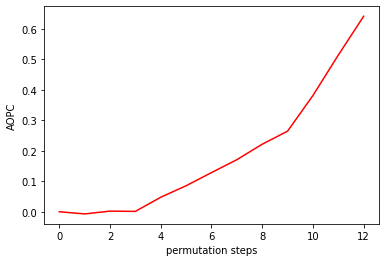

In [62]:
channel_ranking_lrp = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': heatmaps_lrp_mean.cpu().numpy()})
res_lrp_mean_perturb_reverse = calculate_aopc(channel_ranking_lrp, method='lrp-aopc', ascending=False, perturb=True)

#### Random

In [ ]:
channel_ranking_random = pd.DataFrame(data={'channels': channels[selected_channels], 'importance': np.random.randint(12, size=12)})

In [ ]:
channel_ranking_random

In [ ]:
res_random_perturb_reverse = calculate_aopc(channel_ranking_random, method='random-perturb-aopc', ascending=False, perturb=True)

In [ ]:
x = np.arange(len(res_random_perturb_reverse))

In [ ]:
plt.rcParams.update({'font.size': 13})
got_label=False
plt.plot(x, res_deep_lift_perturb_reverse, label  = "Channel-wise DeepLift", color="orange")
plt.plot(x, res_pixel_ocll_perturb_reverse, label  = "Channel-wise Occlusion", color="green")
plt.plot(x, res_pixel_permutated_perturb_reverse, label  = "Pixel-Permutation", color="red")
plt.plot(x, res_random_perturb_reverse, label  = "Random Baseline", color="blue")
plt.xlabel('Perturbation steps')
plt.ylabel('AOPC')
plt.legend()
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-{}.svg".format(dataset_name, str("resnet_all"))))
#plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-{}.png".format(dataset_name, str("resnet_all"))))

##### Calculate the random channel ranking 100 times to estimate the lower und upper bound 

In [ ]:
z=2.576

In [ ]:
upper_border = mean + (z * (std / np.sqrt(len(random_rankings))))

In [ ]:
lower_border = mean - (z * (std / np.sqrt(len(random_rankings))))

In [ ]:
for i in range(100):
    channel_ranking_random = pd.DataFrame(data={'channels': channels[np.asarray(only_channels)], 'importance': np.random.randint(12, size=12)})
    random_rankings.append(calculate_aopc(channel_ranking_random, method='random-perturb-reverse', ascending=False, perturb=True, plot=False))

In [ ]:
plt.rcParams.update({'font.size': 13})
got_label=False
for ranking in random_rankings:
    if not got_label:
        plt.plot(x, ranking, label  = "Random Baseline", color="grey", linewidth=0.5, alpha=0.1)
        got_label=True
    else:
        plt.plot(x, ranking, color="grey", linewidth=0.5, alpha=0.1)
plt.plot(x, res_deep_lift_perturb_reverse, label  = "Channel-wise DeepLift", color="orange")
plt.plot(x, res_pixel_ocll_perturb_reverse, label  = "Channel-wise Occlusion", color="green")
plt.plot(x, res_pixel_permutated_perturb_reverse, label  = "Pixel-Permutation", color="red")
#plt.plot(x, res_random_perturb_reverse, label  = "Random Baseline", color="blue")
plt.xlabel('Perturbation steps')
plt.ylabel('AOPC')
plt.legend()
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-1010-{}.svg".format(dataset_name, str("resnet_all"))))
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-1010-{}.png".format(dataset_name, str("resnet_all"))))